# Most novel fingerprint using k2Sweep

&nbsp;&nbsp;&nbsp;&nbsp;*Andrew Dalke <dalke@dalkescientific.com> 5 October 2021*

When I was in college, a friend of mine (Hi, Craig!) shared an algorithm with me. Given a set of keys, perhaps with multiple key rings, what two keys are farthest apart? (In this case, if you hold up one key by the end, and let the rest hang down, then its farthest key is the one dangling the lowest.)

The algorithm is this: Pick a key and random and let the rest of the keys dangle. At least one key will be lowest. Pick one of these and call it "key1". Hold key1 by its end, and again let the rest of the keys dange. At least one key will be lowest. Pick one of these and call it "key2". The distance between key1 and key2 is the largest possible distance.

Years later I learned this algorithm comes from:

Handler, G. Y. (1973). Minimax Location of a Facility in an Undirected Tree Graph. Transportation Science, 7(3), 287–293. http://www.jstor.org/stable/25767706 

which addresses "the problem of locating the absolute and vertex centers (minimax criterion) of an undirected tree graph." This migh be used, for example, as a way to identify "the location of emergency centers -- e.g., hospitals and police stations."

Handler gives both informal and formal descriptions. Here's the informal one:

Step 1. Choose any point $x$ on tree and find furthest point away &mdash; say $e_1$.

Step 2. Find furthest point away from $e_1$&mdash;say $e_2$.

Step 3. Absolute center is at midpoint of path from $e_1$ to $e_2$. Vertex center is at closest node adjacent to absolute center (perhaps itself.)

This algorithm gives the exact for tree graphs, and provides a lower bound for the maximum distance in other graphs.

## MaxMin

Many years later Roger Sayle presented his work on [MaxMin picking](https://github.com/rdkit/UGM_2017/blob/master/Presentations/Sayle_RDKitDiversity_Berlin17.pdf) at the 2017 RDKit User Group meeting. As some background, "MaxMin" is a method to select the most dissimilar items from a data set; for this essay, diverse fingerprints from a set of fingerprints.

The relevant cheminformatics citation is:

Mark Ashton, John Barnardb, Florence Casset, Michael Charlton, Geoffrey Downs, Dominique Gorse, John Holliday, Roger Lahana and Peter Willett (2002) Identification of Diverse Database Subsets using Property-Based Descriptions. Quant. Struct.-Act. Relat., 21, 598-604. https://doi.org/10.1002/qsar.200290002

and the original algorithm is described in:

Kennard, R. W. and Stone, L. A. (Feb. 1969). Computer Aided Design of Experiments. Technometrics, 11(1), 137-148. https://doi.org/10.2307/1266770 

I'll quote the algorithm from Ashton et al., which is the more mathematically informal of the two:

> Assume that a Subset of $k$ molecules is to be selected from a Dataset   containing $N$ molecules. Then the MaxMin method is as follows:
> 1. Initialise Subset with some appropriately chosen seed compound and set $x:=1$.
> 2. For each of the $N-x$ remaining compounds in Dataset calculate its dissimilarity with each of the $x$ compounds in Subset and retain the smallest of these $x$ dissimilarities for each compound in Dataset.
> 3. Select the molecule from Dataset with the largest value for the smallest dissimilarity calculated in Step 2 and transfer it to Subset.
> 4. Set $x:=x+1$ and return to Step 2 if $x<k$.

The "appropriately chosen seed compound" is further described in the paper as "the compound closest to the centre of the dataset, where centre was defined as the arithmetic mean of the representations of the whole dataset."

It's a pretty straight-forward algorithm to describe. Making an efficient implementation is not so simple!

## SumSweep

Roger and I talked about MaxMin the evening before his talk, and I mentioned how the "pick a key" algorithm seemed appropriate for the seed compound. I was pleased because it was the first time I had found a use for that algorithm.

Roger's talk went into more details on just that point. He pointed out that the [SumSweep](https://www.sciencedirect.com/science/article/pii/S0304397515001644) algorithm, published in 2013, improved on this method. I'll quote from:

Michele Borassi, Pierluigi Crescenzi, Michel Habib, Walter A. Kosters, Andrea Marino, Frank W. Takes (2015) Fast diameter and radius BFS-based computation in (weakly connected) real-world graphs: With an application to the six degrees of separation games. Theoretical Computer Science (586) 59-80. https://doi.org/10.1016/j.tcs.2015.02.033

> ... we propose a new algorithm that computes the radius and the diameter of a weakly connected digraph $G = (V, E)$, by finding bounds through heuristics and improving them until they are validated. Although the worst-case running time is $\mathcal{O}(\lvert{V}\rvert\lvert{E}\rvert)$, we will experimentally show that it performs much better in the case of real-world networks, finding the radius and diameter values after 10–100 BFSs instead of $\lvert{V}\rvert$ BFSs (independently of the value of $\lvert{V}\rvert$), and thus having running time $\mathcal{O}(\lvert{E}\rvert)$ in practice. &hellip; we will compare our algorithm with known approaches &hellip; \[and\] show that, despite its generality, the new algorithm outperforms all previous methods &hellip;.

The [graph diameter](https://en.wikipedia.org/wiki/Distance_(graph_theory)) is the longest of the shortest paths between any two points in a graph. The most novel fingerprint will be one of those two endpoints.

The introduction section of the paper mentions some of the previous heuristics developed to compute the graph diameter, including a number which use the *sweep* approach, where "a new visit of the graph depends on the previous one":

> &hellip; the so-called 2Sweep heuristic picks one of the farthest vertices x from a random vertex r and returns the distance of the farthest vertex from x, while the 4Sweep picks the vertex in the middle of the longest path computed by a 2Sweep execution and performs another 2Sweep from that vertex. Both methods work quite well and very often provide tight bounds. Indeed, in the case of special classes of graphs, they can even be (almost) exact: for example, the 2Sweep method gives the exact value of the diameter for trees, yields an approximation with additive error 1 for chordal graphs and interval graphs, and within 2 for AT-free graphs and hole-free graphs &hellip;

That "2Sweep" is the Handler algorithm I mentioned as a solution to the "most distant pair of keys" problem.

The main point of the SumSweep paper is they develop an exact solution, rather than an heuristic algorithm.

The paper starts by developing the "SumSweep heuristic", then building up to the more complicated "ExactSumSweep algorithm".

## Comparing sweep heuristics

The authors compare different sweep heuristics &mdash; "heuristics" mean these are not exact results, only bounds. These are:

* k-SumSweep: performs a SumSweep from a random vertex, stopping after k BFSs;

* 4RandSamp: returns the maximum eccentricity among four random-chosen vertices;

* 4Sweep: the technique explained in \[[13](https://doi.org/10.1016/j.tcs.2012.09.018)\]

* 2x2Sweep performs twice a 2Sweep \[[22](https://doi.org/10.1145/1412228.1455266)\] starting from two random vertices.

They tested these algorithms against about 30 well-known real-world graphs, with sizes up to 3 million nodes, and compare their performance:

Method	| r	| Std Error
---|:---:|---
4-SumSweep | 99.9830% | 0.0315%
3-SumSweep | 99.9671% | 0.0582%
4Sweep | 99.9353% | 0.1194%
2x2Sweep | 99.9295% | 0.1095%
4RandSamp | 76.9842% | 5.2841%

(They used 4-SumSweep because it does four breadth-first searches, matching the number of BFS used in 4Sweep, 2x2Sweep, and 4RandSamp. They included 3-SumSweep which has one fewer BFS, to show it's also competitive.)

It looks like two iterations of 2Sweep are almost as effective as 4-SumSweep.

The paper later compares ExactSumSweep to other exact methods, which I won't get into.

## Sweep methods for Tanimoto similarity

Roger's MaxMin talk at the 2017 UGM describes using SumSweep to find the furthest apart fingerprints in 250,251 compounds. The $Nx(N-1)/2$ algorithm would take 31B Tanimoto comparisons (though note that with BitBound, k-nearest search with Morgan fingerprints is $\mathcal{O}(n^{~1.8})$ or so, which is still quite slow). With SumSweep, only 43,278,372 Tanimoto comparisons were needed, from $k=173$ sweeps of the fingerprints.

(Incidentally, this shows that Roger's referring to ExactSweepSum, and not the SweepSum heurestic, where $k$ is fixed.)

Curiously, the text also points out "*using Hamming distance on 2K MFP2 FPs*". I say "curious" because I otherwise expect the MaxMin algorithm to use Tanimoto similarity. (That's not essential to MaxMin, but Tanimoto similarity is by far the most common comparison method used in cheminformatics fingerprints.)

After reading through the papers and trying out a few experiments, I realized that Tanimoto similarity can't easily be adapted to the graph distance expected by the sweep methods!

It's easy to turn a Tanimoto into a distance. The Tanimoto similarity score is the domain-specific label for the (Jaccard index)[https://en.wikipedia.org/wiki/Jaccard_index], and $1-$Tanimoto $=$ the Jaccard distance, a.k.a the Soergel distance, which is a metric.

But I found my simple 2Sweep didn't work well at all, not even when used twice in a row. Here's what I mean.

## Most novel fingerprint in ChEMBL

To establish ground-truth, I used chemfp to find the $k=1$ nearest-neighbor for all ~2M fingerprints in ChEMBL 28. I'll copy&amp;paste the results here since the full computation took nearly 7 hours.

```
>>> import chemfp
>>> info = chemfp.simsearch(k=1, NxN=True, targets="/Users/dalke/databases/chembl_28.fpb")
# queries: 100%|████████████████████████████████████████| 2066376/2066376 [6:40:27<00:00, 86.00fps/s]
>>> info.result.to_pandas().sort_values("score")
              query_id      target_id     score
1        CHEMBL4300465  CHEMBL1894305  0.071429
3        CHEMBL1796997  CHEMBL1992013  0.076923
34       CHEMBL2105487  CHEMBL4453320  0.076923
42       CHEMBL4297424    CHEMBL15605  0.076923
15       CHEMBL1201290   CHEMBL448497  0.083333
...                ...            ...       ...
1640316  CHEMBL3218736  CHEMBL3218735  1.000000
1640315  CHEMBL3218735  CHEMBL3218736  1.000000
822918   CHEMBL1321592  CHEMBL1720287  1.000000
1285810  CHEMBL1970820  CHEMBL3325829  1.000000
218733   CHEMBL3088365  CHEMBL3088363  1.000000

[2066376 rows x 3 columns]
```

This means [CHEMBL4300465](https://www.ebi.ac.uk/chembl/compound_report_card/CHEMBL4300465/) &mdash; an atom of radium &mdash; is the fingerprint whose nearest neighbor in ChEMBL is less similar than any other fingerprints' nearest neighbor.

I'll call this "the most novel" fingerprint, though it's not that all novel as a chemical.

## 2Sweep to find the most novel fingerprint

Here's a pretty straight-forward of the 2Sweep algorithm, with some diagnostic print statements to highlight the problem in applying the algorithm to Tanimoto scores:

In [1]:
import chemfp
import numpy as np
import random

# Helper function to get all of the least similar hits.
def get_least_similar(hits):
    arr = hits.as_numpy_array()
    lowest_score = np.amin(arr["score"])
    lowest_indices = arr["index"][np.where(arr["score"] == lowest_score)]
    return lowest_score, lowest_indices

# Implement the 2Sweep algorithm to find a most distant fingerprint.
# See http://www.jstor.org/stable/25767706 
# and https://doi.org/10.1016/j.tcs.2015.02.033
def two_sweep(arena):
    x = random.choice(range(len(arena)))
    fp = arena.fingerprints[x]
        
    hits = arena.threshold_tanimoto_search_fp(fp, threshold=0.0)
    lowest_score, lowest_indices = get_least_similar(hits)
    print(f"Initial pick: {x} ({arena.ids[x]}) lowest score: {lowest_score} count: {len(lowest_indices)}")
    e1 = random.choice(lowest_indices)
    fp1 = arena.fingerprints[e1]

    hits = arena.threshold_tanimoto_search_fp(fp1, threshold=0.0)
    lowest_score, lowest_indices = get_least_similar(hits)
    print(f"Second pick: {e1} ({arena.ids[e1]}) lowest score: {lowest_score} count: {len(lowest_indices)}")
    e2 = random.choice(lowest_indices)
    return e2

# Run it 5 times to see what it selects.
arena = chemfp.load_fingerprints("/Users/dalke/databases/chembl_28.fpb")
for i in range(1, 6):
    print(f"Attempt {i}")
    idx = two_sweep(arena)
    print(f"two_sweep suggests:", idx, arena.ids[idx])
    fp = arena.fingerprints[idx]
    hits = arena.knearest_tanimoto_search_fp(fp, k=2, threshold=0.0)
    print(hits.to_pandas())

Attempt 1
Initial pick: 451137 (CHEMBL470020) lowest score: 0.0 count: 830
Second pick: 214 (CHEMBL1348453) lowest score: 0.0 count: 1783915
two_sweep suggests: 687642 CHEMBL4589157
       target_id     score
0  CHEMBL4589157  1.000000
1  CHEMBL1563616  0.636364
Attempt 2
Initial pick: 1339299 (CHEMBL1642362) lowest score: 0.0 count: 920
Second pick: 30234 (CHEMBL3559315) lowest score: 0.0 count: 155125
two_sweep suggests: 1331205 CHEMBL1312502
       target_id     score
0  CHEMBL1312502  1.000000
1  CHEMBL1497853  0.709677
Attempt 3
Initial pick: 835421 (CHEMBL1879443) lowest score: 0.0 count: 1176
Second pick: 20683 (CHEMBL284190) lowest score: 0.0 count: 124693
two_sweep suggests: 396584 CHEMBL312131
      target_id     score
0  CHEMBL312131  1.000000
1    CHEMBL7643  0.772727
Attempt 4
Initial pick: 348637 (CHEMBL268644) lowest score: 0.0 count: 514
Second pick: 2187 (CHEMBL443082) lowest score: 0.0 count: 623228
two_sweep suggests: 609011 CHEMBL39337
     target_id  score
0  CHEMB

Those are not novel picks at all!

The problem seems to be that for any initial choice there are hundreds or even thousands of fingerprints with a score of 0.0. These in turn have tens or hundreds of thousands of neighbors with a score of 0.0. And yet most of those have close-by nearest neighbors.

I think the problem here is that the sweep methods are typically used in sparse graphs, and with a distance measure like Manhattan, which it a bit more neighborhood preserving than the Jaccard distance. (I'm hand-waving here - I only used to know some mathematics.)

## FourSweep

The SumSweep paper suggested FourSweep as an alternative. I'll try it out, though I'll be a biy wasteful and re-do a fingerprint search so I can reuse a slightly modified version of TwoSweep.

In [2]:
import chemfp
import numpy as np
import random

# Helper function to get all of the least similar hits.
def get_least_similar(hits):
    arr = hits.as_numpy_array()
    lowest_score = np.amin(arr["score"])
    lowest_indices = arr["index"][np.where(arr["score"] == lowest_score)]
    return lowest_score, lowest_indices

# Implement the 2Sweep algorithm to find a most distant fingerprint.
# See http://www.jstor.org/stable/25767706 
# and https://doi.org/10.1016/j.tcs.2015.02.033
def two_sweep(arena, idx=None):
    if idx is None:
        x = random.choice(range(len(arena)))
    else:
        x = idx
    fp = arena.fingerprints[x]
        
    hits = arena.threshold_tanimoto_search_fp(fp, threshold=0.0)
    lowest_score, lowest_indices = get_least_similar(hits)
    print(f"Initial pick: {x} ({arena.ids[x]}) lowest score: {lowest_score} count: {len(lowest_indices)}")
    e1 = random.choice(lowest_indices)
    fp1 = arena.fingerprints[e1]

    hits = arena.threshold_tanimoto_search_fp(fp1, threshold=0.0)
    lowest_score, lowest_indices = get_least_similar(hits)
    print(f"Second pick: {e1} ({arena.ids[e1]}) lowest score: {lowest_score} count: {len(lowest_indices)}")
    e2 = random.choice(lowest_indices)
    return e2

def four_sweep(arena, idx=None):
    # the 4Sweep picks the vertex in the middle of the longest path computed by a
    # 2Sweep execution and performs another 2Sweep from that vertex
    outlier_idx = two_sweep(arena, idx=idx)
    fp = arena.fingerprints[outlier_idx]
    hits = arena.threshold_tanimoto_search_fp(fp, threshold=0.0)
    hits.reorder("increasing-score")
    median_idx = hits.as_numpy_array()["index"][len(hits)//2]
    return two_sweep(arena, idx=median_idx)

# Run it 5 times to see the prediction.
arena = chemfp.load_fingerprints("/Users/dalke/databases/chembl_28.fpb")
for i in range(1, 6):
    print(f"Attempt {i}")
    idx = four_sweep(arena)
    print(f"four_sweep suggests:", idx, arena.ids[idx])
    fp = arena.fingerprints[idx]
    hits = arena.knearest_tanimoto_search_fp(fp, k=2, threshold=0.0)
    print(hits.to_pandas())


Attempt 1
Initial pick: 591060 (CHEMBL2158376) lowest score: 0.0 count: 636
Second pick: 17265 (CHEMBL601610) lowest score: 0.0 count: 441364
Initial pick: 1568846 (CHEMBL4284399) lowest score: 0.0 count: 224
Second pick: 5 (CHEMBL4597517) lowest score: 0.0 count: 2051994
four_sweep suggests: 342920 CHEMBL46048
      target_id     score
0   CHEMBL46048  1.000000
1  CHEMBL294964  0.684211
Attempt 2
Initial pick: 1757973 (CHEMBL111003) lowest score: 0.0 count: 204
Second pick: 486 (CHEMBL22830) lowest score: 0.0 count: 691007
Initial pick: 1541553 (CHEMBL1338892) lowest score: 0.0 count: 233
Second pick: 192 (CHEMBL444147) lowest score: 0.0 count: 1356958
four_sweep suggests: 318028 CHEMBL1313262
       target_id     score
0  CHEMBL1313262  1.000000
1  CHEMBL3234639  0.486486
Attempt 3
Initial pick: 2037111 (CHEMBL2009921) lowest score: 0.0 count: 206
Second pick: 225 (CHEMBL1887585) lowest score: 0.0 count: 1491362
Initial pick: 2017082 (CHEMBL438297) lowest score: 0.0 count: 155
Second

It does not seem better than 2Sweep.

## RandSamp

The SumSweep paper also compares against 4RandSamp, that is, select the furthest point from four randomly selected intial points. I'll give it a go:

In [3]:
import chemfp
import numpy as np
import random

# Helper function to get all of the least similar hits.
def get_least_similar(hits):
    arr = hits.as_numpy_array()
    lowest_score = np.amin(arr["score"])
    lowest_indices = arr["index"][np.where(arr["score"] == lowest_score)]
    return lowest_score, lowest_indices

def rand_samp(arena):
    x = random.choice(range(len(arena)))
    fp = arena.fingerprints[x]
        
    hits = arena.threshold_tanimoto_search_fp(fp, threshold=0.0)
    lowest_score, lowest_indices = get_least_similar(hits)
    #print(f"Initial pick: {x} ({arena.ids[x]}) lowest score: {lowest_score} count: {len(lowest_indices)}")
    return lowest_score, random.choice(lowest_indices)

def four_rand_samp(arena):
    return min(rand_samp(arena) for i in range(4))[1]

# Run it 10 times to see the prediction.
arena = chemfp.load_fingerprints("/Users/dalke/databases/chembl_28.fpb")
for i in range(1, 11):
    print(f"Attempt {i}")
    idx = four_rand_samp(arena)
    print(f"four_rand_samp suggests:", idx, arena.ids[idx])
    fp = arena.fingerprints[idx]
    hits = arena.knearest_tanimoto_search_fp(fp, k=2, threshold=0.0)
    print(hits.to_pandas())


Attempt 1
four_rand_samp suggests: 66 CHEMBL1201084
       target_id     score
0  CHEMBL1201084  1.000000
1     CHEMBL1528  0.333333
Attempt 2
four_rand_samp suggests: 44 CHEMBL4297365
       target_id  score
0  CHEMBL4297365  1.000
1  CHEMBL1797281  0.125
Attempt 3
four_rand_samp suggests: 43 CHEMBL4298415
       target_id  score
0  CHEMBL4298415    1.0
1  CHEMBL1644030    0.5
Attempt 4
four_rand_samp suggests: 91 CHEMBL2106539
       target_id     score
0  CHEMBL2106539  1.000000
1    CHEMBL69710  0.333333
Attempt 5
four_rand_samp suggests: 3 CHEMBL1796997
       target_id     score
0  CHEMBL1796997  1.000000
1  CHEMBL1992013  0.076923
Attempt 6
four_rand_samp suggests: 222 CHEMBL3833314
       target_id  score
0  CHEMBL3833314    1.0
1  CHEMBL3833401    0.8
Attempt 7
four_rand_samp suggests: 824 CHEMBL1627016
       target_id     score
0  CHEMBL1627016  1.000000
1  CHEMBL1741048  0.416667
Attempt 8
four_rand_samp suggests: 349 CHEMBL2106634
       target_id     score
0  CHEMBL210663

That's looking may a bit better than 2Sweep or 4Sweep? Hmm!

## Where is the most novel fingerprint?

One thing I've noticed is the most novel fingerprint tends to occur early in the arena. For example, CHEMBL4300465 is the second fingerprint.

In [4]:
arena.get_index_by_id("CHEMBL4300465")

1

Chemfp orders the fingerprints by popcount, that is, the fingerprints with 0 bits set come first, then those with 1 bit set, etc. This ordering makes it easy to apply the BitBound algorithm to prune search space. And CHEMBL4300465, which is an atom of radium, only sets 1 bit.

In [5]:
from chemfp import bitops
bitops.byte_to_bitlist(arena.fingerprints[1])

[775]

Furthermore, chemfp's single-fingerprint threshold search examines the fingerprints in linear order, from the lowest BitBound range to highest. Thus, it's very likely the most novel fingerprint will be one of the first fingerprints in the search results.

I'll examine that concept by selecting multiple fingerprint subsets and using a k=1 nearest-neighbor NxN search to find the most position of the most novel fingerprint. Here's the structure of the code, broken down into steps.

First, create a subset of 10,000 randomly chosen fingerprints and do the k=1 NN search. (I'll specify a seed for the RNG to make the results reproducible in this notebook.)

In [6]:
import chemfp

arena = chemfp.load_fingerprints("/Users/dalke/databases/chembl_28.fpb")

subset = arena.sample(10_000, rng=20211005)
search = chemfp.simsearch(NxN=True, k=1, targets=subset)
search


queries:   0%|          | 0/10000 [00:00<?, ?fps/s]

SimsearchInfo('1-nearest Tanimoto NxN search. #fingerprints=10000 (search: 1.13 s total: 1.13 s)'", result=SearchResults(#queries=10000, #targets=10000))

Then find the most novel fingerprint (the query id with the smallest score), and get its position in the subset arena:

In [7]:
search.result.to_pandas().sort_values("score")

,query_id,target_id,score
0,CHEMBL1236802,CHEMBL177777,0.047619
20,CHEMBL1976857,CHEMBL1650635,0.130435
8,CHEMBL3186939,CHEMBL2407306,0.147059
9340,CHEMBL1185344,CHEMBL3451907,0.147368
60,CHEMBL1990430,CHEMBL333967,0.159091
...,...,...,...
9852,CHEMBL386567,CHEMBL385148,1.000000
9360,CHEMBL1208577,CHEMBL1208490,1.000000
616,CHEMBL1707757,CHEMBL4217734,1.000000
651,CHEMBL4217734,CHEMBL1707757,1.000000


In [8]:
subset.get_index_by_id("CHEMBL1236802")

0

In [9]:
arena.get_index_by_id("CHEMBL1236802")

26

Wow! That was the first index in the subset, and the 27th in the original arena.

I'll automate this to look at the distribution of locations of the most novel fingerprint.

In [10]:
import chemfp

arena = chemfp.load_fingerprints("/Users/dalke/databases/chembl_28.fpb")

for i in range(20):
    subset = arena.sample(10_000)
    search = chemfp.simsearch(NxN=True, k=1, targets=subset, progress=False)
    df = search.result.to_pandas().sort_values("score")
    most_novel = df.loc[0]
    query_id = most_novel["query_id"]
    print("id:", query_id, "score:", most_novel["score"],
          "in subset:", subset.get_index_by_id(query_id),
          "in ChEMBL:", arena.get_index_by_id(query_id))

id: CHEMBL2105054 score: 0.14285714285714285 in subset: 0 in ChEMBL: 351
id: CHEMBL3183999 score: 0.28 in subset: 0 in ChEMBL: 1143
id: CHEMBL452370 score: 0.125 in subset: 0 in ChEMBL: 196
id: CHEMBL2105877 score: 0.06666666666666667 in subset: 0 in ChEMBL: 86
id: CHEMBL117822 score: 0.05405405405405406 in subset: 0 in ChEMBL: 51
id: CHEMBL1200739 score: 0.07142857142857142 in subset: 0 in ChEMBL: 12
id: CHEMBL2107816 score: 0.08695652173913043 in subset: 0 in ChEMBL: 82
id: CHEMBL2220705 score: 0.05263157894736842 in subset: 0 in ChEMBL: 165
id: CHEMBL125278 score: 0.25 in subset: 0 in ChEMBL: 379
id: CHEMBL3185957 score: 0.058823529411764705 in subset: 0 in ChEMBL: 126
id: CHEMBL1412 score: 0.21739130434782608 in subset: 0 in ChEMBL: 288
id: CHEMBL4460016 score: 0.1 in subset: 0 in ChEMBL: 60
id: CHEMBL1208642 score: 0.16666666666666666 in subset: 0 in ChEMBL: 582
id: CHEMBL452651 score: 0.14285714285714285 in subset: 0 in ChEMBL: 109
id: CHEMBL452940 score: 0.14705882352941177 in s

That's incredible! The most novel fingerprint is always the first one!

That's probably because these have few bits set, so I'll try creating subsets near the middle of the ChEMBL data set, so they all have about the same number of bits set.

In [11]:
import chemfp
import random

arena = chemfp.load_fingerprints("/Users/dalke/databases/chembl_28.fpb")
N = len(arena)
for i in range(20):
    # Select 10,000 fingerprints with a decile of the median.
    indices = random.sample(range(int(N * 0.4), int(N*0.6)), 10_000)
    subset = arena.copy(indices = indices)
    search = chemfp.simsearch(NxN=True, k=1, targets=subset, progress=False)
    df = search.result.to_pandas().sort_values("score")
    most_novel = df.iloc[0]
    query_id = most_novel["query_id"]
    print("id:", query_id, "score:", most_novel["score"],
          "in subset:", subset.get_index_by_id(query_id),
          "in ChEMBL:", arena.get_index_by_id(query_id))

id: CHEMBL1322547 score: 0.1744186046511628 in subset: 9317 in ChEMBL: 1212468
id: CHEMBL4301938 score: 0.16470588235294117 in subset: 7224 in ChEMBL: 1127852
id: CHEMBL1256918 score: 0.1744186046511628 in subset: 7829 in ChEMBL: 1150206
id: CHEMBL4161403 score: 0.1744186046511628 in subset: 5568 in ChEMBL: 1058606
id: CHEMBL4579847 score: 0.17647058823529413 in subset: 9152 in ChEMBL: 1205046
id: CHEMBL253045 score: 0.1875 in subset: 2529 in ChEMBL: 934846
id: CHEMBL3211812 score: 0.175 in subset: 2021 in ChEMBL: 911911
id: CHEMBL113882 score: 0.175 in subset: 2501 in ChEMBL: 930411
id: CHEMBL4176522 score: 0.19230769230769232 in subset: 835 in ChEMBL: 860141
id: CHEMBL559282 score: 0.18823529411764706 in subset: 7697 in ChEMBL: 1141596
id: CHEMBL3402254 score: 0.18518518518518517 in subset: 5385 in ChEMBL: 1045867
id: CHEMBL1256918 score: 0.1927710843373494 in subset: 7864 in ChEMBL: 1150206
id: CHEMBL1928147 score: 0.175 in subset: 1799 in ChEMBL: 901349
id: CHEMBL1091490 score: 0.1

That's much more distributed among the 10,000 fingerprints.

## 2Sweep and median-ish arenas

Perhaps 2Sweep will work when there's more of a distribution in the fingerprint locations?

In [12]:
import chemfp
import random
import numpy as np

# Helper function to get all of the least similar hits.
def get_least_similar(hits):
    arr = hits.as_numpy_array()
    lowest_score = np.amin(arr["score"])
    lowest_indices = arr["index"][np.where(arr["score"] == lowest_score)]
    return lowest_score, lowest_indices

def two_sweep(arena, idx=None):
    if idx is None:
        x = random.choice(range(len(arena)))
    else:
        x = idx
    fp = arena.fingerprints[x]
        
    hits = arena.threshold_tanimoto_search_fp(fp, threshold=0.0)
    lowest_score, lowest_indices = get_least_similar(hits)
    #print(f"Initial pick: {x} ({arena.ids[x]}) lowest score: {lowest_score} count: {len(lowest_indices)}")
    e1 = random.choice(lowest_indices)
    fp1 = arena.fingerprints[e1]

    hits = arena.threshold_tanimoto_search_fp(fp1, threshold=0.0)
    lowest_score, lowest_indices = get_least_similar(hits)
    #print(f"Second pick: {e1} ({arena.ids[e1]}) lowest score: {lowest_score} count: {len(lowest_indices)}")
    e2 = random.choice(lowest_indices)
    return e2


arena = chemfp.load_fingerprints("/Users/dalke/databases/chembl_28.fpb")
N = len(arena)
actual = []
predicted = []
for i in range(20):
    # Select 10,000 fingerprints with a decile of the median.
    indices = random.sample(range(int(N * 0.4), int(N*0.6)), 10_000)
    subset = arena.copy(indices = indices)
    search = chemfp.simsearch(NxN=True, k=1, targets=subset, progress=False)
    df = search.result.to_pandas().sort_values("score")
    most_novel = df.iloc[0]
    query_id, query_score = most_novel["query_id"], most_novel["score"]
    print("id:", query_id, "score:", query_score,
          "in subset:", subset.get_index_by_id(query_id),
          "in ChEMBL:", arena.get_index_by_id(query_id))
    actual.append(query_score)
    
    sweep_idx = two_sweep(subset)
    sweep_id, sweep_fp = subset[sweep_idx]
    hits = subset.knearest_tanimoto_search_fp(sweep_fp, k=2, threshold=0.0)
    (idx1, score1), (idx2, score2) = hits.get_indices_and_scores()
    if idx1 == sweep_idx:
        sweep_score = score2
    else:
        sweep_score = score1
    print("  two_sweep:", sweep_id, "score:", sweep_score,
          "in subset:", sweep_idx)
    predicted.append(sweep_score)

id: CHEMBL551238 score: 0.175 in subset: 3660 in ChEMBL: 973372
  two_sweep: CHEMBL3311109 score: 0.4393939393939394 in subset: 882
id: CHEMBL118640 score: 0.1724137931034483 in subset: 5726 in ChEMBL: 1063092
  two_sweep: CHEMBL3120602 score: 0.28 in subset: 444
id: CHEMBL510585 score: 0.17073170731707318 in subset: 4439 in ChEMBL: 1008598
  two_sweep: CHEMBL3439904 score: 0.30666666666666664 in subset: 2117
id: CHEMBL4301938 score: 0.17857142857142858 in subset: 7263 in ChEMBL: 1127852
  two_sweep: CHEMBL3982628 score: 0.4 in subset: 788
id: CHEMBL27450 score: 0.18181818181818182 in subset: 8779 in ChEMBL: 1188739
  two_sweep: CHEMBL3288086 score: 0.5303030303030303 in subset: 8393
id: CHEMBL1173810 score: 0.18072289156626506 in subset: 6114 in ChEMBL: 1081233
  two_sweep: CHEMBL1335151 score: 0.5833333333333334 in subset: 1418
id: CHEMBL3238501 score: 0.189873417721519 in subset: 3680 in ChEMBL: 978090
  two_sweep: CHEMBL4126476 score: 0.5873015873015873 in subset: 7163
id: CHEMBL28

Doesn't look so good. I saved the exact minimum and predicted minimum so I can plot them.

<AxesSubplot:xlabel='actual', ylabel='2Sweep'>

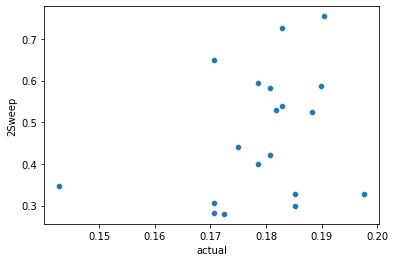

In [13]:
import pandas as pd
import seaborn as sns
df = pd.DataFrame.from_dict({"actual": actual, "2Sweep": predicted})
sns.scatterplot(x="actual", y="2Sweep", data=df)

## 4RandSamp and median-ish arena

I'll do the same analysis using 4RandSamp, and also compare the results to 2Sweep

In [14]:
import chemfp
import random
import numpy as np

# Helper function to get all of the least similar hits.
def get_least_similar(hits):
    arr = hits.as_numpy_array()
    lowest_score = np.amin(arr["score"])
    lowest_indices = arr["index"][np.where(arr["score"] == lowest_score)]
    return lowest_score, lowest_indices

def two_sweep(arena, idx=None):
    if idx is None:
        x = random.choice(range(len(arena)))
    else:
        x = idx
    fp = arena.fingerprints[x]
        
    hits = arena.threshold_tanimoto_search_fp(fp, threshold=0.0)
    lowest_score, lowest_indices = get_least_similar(hits)
    #print(f"Initial pick: {x} ({arena.ids[x]}) lowest score: {lowest_score} count: {len(lowest_indices)}")
    e1 = random.choice(lowest_indices)
    fp1 = arena.fingerprints[e1]

    hits = arena.threshold_tanimoto_search_fp(fp1, threshold=0.0)
    lowest_score, lowest_indices = get_least_similar(hits)
    #print(f"Second pick: {e1} ({arena.ids[e1]}) lowest score: {lowest_score} count: {len(lowest_indices)}")
    e2 = random.choice(lowest_indices)
    return e2

def rand_samp(arena):
    x = random.choice(range(len(arena)))
    fp = arena.fingerprints[x]
        
    hits = arena.threshold_tanimoto_search_fp(fp, threshold=0.0)
    lowest_score, lowest_indices = get_least_similar(hits)
    #print(f"Initial pick: {x} ({arena.ids[x]}) lowest score: {lowest_score} count: {len(lowest_indices)}")
    return lowest_score, random.choice(lowest_indices)

def four_rand_samp(arena):
    return min(rand_samp(arena) for i in range(4))[1]

def get_id_and_novelty_score(arena, start_idx):
    id, fp = arena[start_idx]
    hits = arena.knearest_tanimoto_search_fp(fp, k=2, threshold=0.0)
    (idx1, score1), (idx2, score2) = hits.get_indices_and_scores()
    if idx1 == start_idx:
        score = score2
    else:
        score = score1
    return id, score

arena = chemfp.load_fingerprints("/Users/dalke/databases/chembl_28.fpb")
N = len(arena)
actual = []
predicted_2sweep = []
predicted_4samp = []
for i in range(20):
    # Select 10,000 fingerprints within a decile of the median.
    indices = random.sample(range(int(N * 0.4), int(N*0.6)), 10_000)
    subset = arena.copy(indices = indices)
    search = chemfp.simsearch(NxN=True, k=1, targets=subset, progress=False)
    df = search.result.to_pandas().sort_values("score")
    most_novel = df.iloc[0]
    query_id, query_score = most_novel["query_id"], most_novel["score"]
    print("id:", query_id, "score:", query_score,
          "in subset:", subset.get_index_by_id(query_id),
          "in ChEMBL:", arena.get_index_by_id(query_id))
    actual.append(query_score)

    sweep_idx = two_sweep(subset)
    sweep_id, sweep_score = get_id_and_novelty_score(subset, sweep_idx)
    predicted_2sweep.append(sweep_score)

    samp_idx = four_rand_samp(subset)
    samp_id, samp_score = get_id_and_novelty_score(subset, samp_idx)
    predicted_4samp.append(samp_score)

    print(f"  2sweep: {sweep_id} score: {sweep_score} four_rand_samp: {samp_id} score: {samp_score}")

id: CHEMBL222861 score: 0.189873417721519 in subset: 2596 in ChEMBL: 933873
  2sweep: CHEMBL2029073 score: 0.375 four_rand_samp: CHEMBL2304268 score: 0.21686746987951808
id: CHEMBL1965647 score: 0.17073170731707318 in subset: 6664 in ChEMBL: 1100141
  2sweep: CHEMBL4062891 score: 0.4696969696969697 four_rand_samp: CHEMBL2069060 score: 0.3157894736842105
id: CHEMBL3929429 score: 0.1875 in subset: 5597 in ChEMBL: 1055210
  2sweep: CHEMBL4085790 score: 0.2876712328767123 four_rand_samp: CHEMBL1078744 score: 0.4166666666666667
id: CHEMBL439151 score: 0.18604651162790697 in subset: 7726 in ChEMBL: 1146431
  2sweep: CHEMBL4448279 score: 0.3013698630136986 four_rand_samp: CHEMBL474263 score: 0.3472222222222222
id: CHEMBL4542780 score: 0.18292682926829268 in subset: 6073 in ChEMBL: 1075634
  2sweep: CHEMBL1093818 score: 0.5625 four_rand_samp: CHEMBL468875 score: 0.42028985507246375
id: CHEMBL1883321 score: 0.18072289156626506 in subset: 1792 in ChEMBL: 901043
  2sweep: CHEMBL2431825 score: 0.3

Text(0, 0.5, 'predicted')

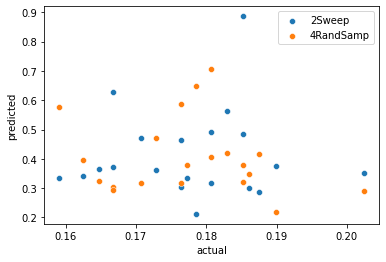

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.DataFrame.from_dict({
    "actual": actual, "2Sweep": predicted_2sweep, "4RandSamp": predicted_4samp})
ax = sns.scatterplot(x="actual", y="2Sweep", data=df, label="2Sweep")
sns.scatterplot(x="actual", y="4RandSamp", data=df, label="4RandSamp")
plt.ylabel("predicted")

There's neither rhyme nor reason to when one is better than the other, and they aren't that good.

## k2Sweep

I've come up with a different heuristic, which I call k2Sweep.

Pick a random point, find all similarity scores, and sort from most novel to least (least similar to most).

Go through the list of hits, and do a $k=2$ nearest-neighbor search. Keep doing this until 100 such searches fail to improve the score.

Repeat this $n$ times. I'll try 1, 5 and 10 times.

Here's an implementation:

id: CHEMBL1173810 score: 0.18072289156626506 in subset: 6065 in ChEMBL: 1081233
  1k2sweep: CHEMBL4527714 score: 0.20238095238095238
  5k2sweep: CHEMBL102784 score: 0.22784810126582278
  10k2sweep: CHEMBL4211572 score: 0.2077922077922078
id: CHEMBL292338 score: 0.18292682926829268 in subset: 6176 in ChEMBL: 1082857
  1k2sweep: CHEMBL292338 score: 0.18292682926829268
  5k2sweep: CHEMBL292338 score: 0.18292682926829268
  10k2sweep: CHEMBL1789466 score: 0.22784810126582278
id: CHEMBL520039 score: 0.18604651162790697 in subset: 9102 in ChEMBL: 1202045
  1k2sweep: CHEMBL2219744 score: 0.19230769230769232
  5k2sweep: CHEMBL2219744 score: 0.19230769230769232
  10k2sweep: CHEMBL62401 score: 0.19753086419753085
id: CHEMBL2374108 score: 0.18292682926829268 in subset: 5141 in ChEMBL: 1039463
  1k2sweep: CHEMBL1187323 score: 0.1875
  5k2sweep: CHEMBL1187323 score: 0.1875
  10k2sweep: CHEMBL1187323 score: 0.1875
id: CHEMBL4457240 score: 0.17857142857142858 in subset: 2576 in ChEMBL: 934948
  1k2swe

Text(0, 0.5, 'predicted')

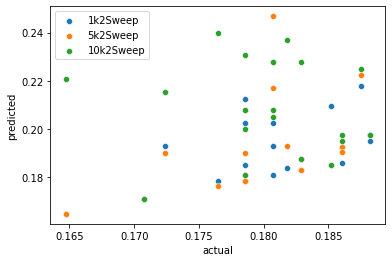

In [16]:
import chemfp
import random
import numpy as np

def k2sweep(arena, M=100):
    start_idx = random.choice(range(len(arena)))
    fp = arena.fingerprints[start_idx]
    hits = arena.threshold_tanimoto_search_fp(fp, threshold=0.0)
    hits.reorder("increasing-score")
    largest = hits.as_ctypes()[-1]    # this approch doesn't require NumPy

    # Initialize with the initial pick on the off-chance that it's the
    # most novel.
    smallest_idx, smallest_score = start_idx, largest.score
    #print("Starting with", smallest_idx, smallest_score)

    # Keep trying all hits, starting from most dissimilar.
    num_tries = 0
    for (idx, min_score) in hits.get_indices_and_scores():
        fp = arena.fingerprints[idx]
        # Do a k=2 search.
        two_hits = arena.knearest_tanimoto_search_fp(fp, k=2, threshold=0.0)
        # The query itself will always be a 1.0 hit, so only look at the second.
        (_, k2_score) = two_hits.get_scores()

        #print("k2_score", idx, k2_score)
        if k2_score < smallest_score:
            num_tries = 0
            smallest_idx, smallest_score = idx, k2_score
        else:
            # Keep trying until M attempts in a row fail to improve things.
            num_tries += 1
            if num_tries > M:
                break
    return smallest_idx, smallest_score

def n_k2sweep(arena, n, M=100):
    return min(k2sweep(arena, M) for i in range(n))
        
arena = chemfp.load_fingerprints("/Users/dalke/databases/chembl_28.fpb")
N = len(arena)
actual = []
predicted_1k2sweep = []
predicted_5k2sweep = []
predicted_10k2sweep = []
for i in range(20):
    # Select 10,000 fingerprints within a decile of the median.
    indices = random.sample(range(int(N * 0.4), int(N*0.6)), 10_000)
    subset = arena.copy(indices = indices)
    search = chemfp.simsearch(NxN=True, k=1, targets=subset, progress=False)
    df = search.result.to_pandas().sort_values("score")
    most_novel = df.iloc[0]
    query_id, query_score = most_novel["query_id"], most_novel["score"]
    print("id:", query_id, "score:", query_score,
          "in subset:", subset.get_index_by_id(query_id),
          "in ChEMBL:", arena.get_index_by_id(query_id))
    actual.append(query_score)

    sweep_idx, sweep_score = n_k2sweep(subset, 1)
    sweep_id = subset.ids[sweep_idx]
    print(f"  1k2sweep: {sweep_id} score: {sweep_score}")
    predicted_1k2sweep.append(sweep_score)

    sweep_idx, sweep_score = n_k2sweep(subset, 5)
    sweep_id = subset.ids[sweep_idx]
    print(f"  5k2sweep: {sweep_id} score: {sweep_score}")
    predicted_5k2sweep.append(sweep_score)

    sweep_idx, sweep_score = n_k2sweep(subset, 10)
    sweep_id = subset.ids[sweep_idx]
    print(f"  10k2sweep: {sweep_id} score: {sweep_score}")
    predicted_10k2sweep.append(sweep_score)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame.from_dict(
    {"actual": actual, "1k2Sweep": predicted_1k2sweep,
     "5k2Sweep": predicted_5k2sweep, "10k2Sweep": predicted_10k2sweep})
sns.scatterplot(x="actual", y="1k2Sweep", data=df, label="1k2Sweep")
sns.scatterplot(x="actual", y="5k2Sweep", data=df, label="5k2Sweep")
sns.scatterplot(x="actual", y="10k2Sweep", data=df, label="10k2Sweep")
plt.ylabel("predicted")

The predicted most-novel fingerprint results are quite a bit closer than 2Sweep or 4RandSamp. To make it perhaps easier to interpret, I'll scale the predicted novelty score by the actual novelty score:

Text(0, 0.5, 'predicted/actual')

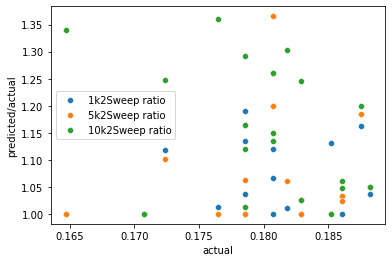

In [17]:
df["1k2_ratio"] = df["1k2Sweep"] / df["actual"]
df["5k2_ratio"] = df["5k2Sweep"] / df["actual"]
df["10k2_ratio"] = df["10k2Sweep"] / df["actual"]
sns.scatterplot(x="actual", y="1k2_ratio", data=df, label="1k2Sweep ratio")
sns.scatterplot(x="actual", y="5k2_ratio", data=df, label="5k2Sweep ratio")
sns.scatterplot(x="actual", y="10k2_ratio", data=df, label="10k2Sweep ratio")
plt.ylabel("predicted/actual")


It looks like using 10 initial seeds isn't clearly much better than 5 ... or 1.

What about searching until there are 10, 20, 50, 200, or 500 non-improving searches, instead of 100? I'll re-use the functions already defined:

In [18]:
arena = chemfp.load_fingerprints("/Users/dalke/databases/chembl_28.fpb")
N = len(arena)
actual = []
predicted_k2sweep_10 = []
predicted_k2sweep_20 = []
predicted_k2sweep_50 = []
predicted_k2sweep_100 = []
predicted_k2sweep_200 = []
predicted_k2sweep_500 = []
for i in range(20):
    # Select 10,000 fingerprints within a decile of the median.
    indices = random.sample(range(int(N * 0.4), int(N*0.6)), 10_000)
    subset = arena.copy(indices = indices)
    search = chemfp.simsearch(NxN=True, k=1, targets=subset, progress=False)
    df = search.result.to_pandas().sort_values("score")
    most_novel = df.iloc[0]
    query_score = most_novel["score"]
    actual.append(query_score)

    sweep_idx, sweep_score = n_k2sweep(subset, 1, 10)
    predicted_k2sweep_10.append(sweep_score)
    
    sweep_idx, sweep_score = n_k2sweep(subset, 1, 20)
    predicted_k2sweep_20.append(sweep_score)
    
    sweep_idx, sweep_score = n_k2sweep(subset, 1, 50)
    predicted_k2sweep_50.append(sweep_score)
    
    sweep_idx, sweep_score = n_k2sweep(subset, 1, 100)
    predicted_k2sweep_100.append(sweep_score)

    sweep_idx, sweep_score = n_k2sweep(subset, 1, 200)
    predicted_k2sweep_200.append(sweep_score)

    sweep_idx, sweep_score = n_k2sweep(subset, 1, 500)
    predicted_k2sweep_500.append(sweep_score)

Text(0, 0.5, 'predicted')

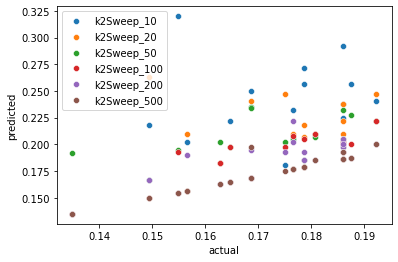

In [19]:
df = pd.DataFrame.from_dict(
    {"actual": actual,
     "k2Sweep_10": predicted_k2sweep_10,
     "k2Sweep_20": predicted_k2sweep_20,
     "k2Sweep_50": predicted_k2sweep_50,
     "k2Sweep_100": predicted_k2sweep_100,
     "k2Sweep_200": predicted_k2sweep_200,
     "k2Sweep_500": predicted_k2sweep_500,
    })
sns.scatterplot(x="actual", y="k2Sweep_10", data=df, label="k2Sweep_10")
sns.scatterplot(x="actual", y="k2Sweep_20", data=df, label="k2Sweep_20")
sns.scatterplot(x="actual", y="k2Sweep_50", data=df, label="k2Sweep_50")
sns.scatterplot(x="actual", y="k2Sweep_100", data=df, label="k2Sweep_100")
sns.scatterplot(x="actual", y="k2Sweep_200", data=df, label="k2Sweep_200")
sns.scatterplot(x="actual", y="k2Sweep_500", data=df, label="k2Sweep_500")
plt.ylabel("predicted")

Eyeballing it, it looks like more-is-better, and that 200 seems like an okay stopping point.

Do bear in mind that I deliberately constructed these data sets to make it more difficult to find the most novel fingerprint!

## k2Sweep on a few data sets

I've been testing against ChEMBL, or subsets thereof. I'll try on a few full data sets on have on-hand, again, with different numbers of nearest-neighbor searches for each case:

In [20]:
import chemfp
import random
import numpy as np

def k2sweep(arena, M=200):
    start_idx = random.choice(range(len(arena)))
    fp = arena.fingerprints[start_idx]
    hits = arena.threshold_tanimoto_search_fp(fp, threshold=0.0)
    hits.reorder("increasing-score")
    largest = hits.as_ctypes()[-1]    # this approch doesn't require NumPy

    # Initialize with the initial pick on the off-chance that it's the
    # most novel.
    smallest_idx, smallest_score = start_idx, largest.score
    #print("Starting with", smallest_idx, smallest_score)

    # Keep trying all hits, starting from most dissimilar.
    num_tries = 0
    for (idx, min_score) in hits.get_indices_and_scores():
        fp = arena.fingerprints[idx]
        # Do a k=2 search.
        two_hits = arena.knearest_tanimoto_search_fp(fp, k=2, threshold=0.0)
        # The query itself will always be a 1.0 hit, so only look at the second.
        (_, k2_score) = two_hits.get_scores()

        #print("k2_score", idx, k2_score)
        if k2_score < smallest_score:
            num_tries = 0
            smallest_idx, smallest_score = idx, k2_score
        else:
            # Keep trying until M attempts in a row fail to improve things.
            num_tries += 1
            if num_tries > M:
                break
    return smallest_idx, smallest_score

import time
for label, filename in (
        ("Asinex Gold and Platinum", "/Users/dalke/databases/2021-02-Asinex-GoldPlatinum.fpb"),
        ("NCI August 2000", "/Users/dalke/databases/NCI_aug00_2D_morgan2.fpb"),
        ("ChEMBL 28", "/Users/dalke/databases/chembl_28.fpb"),
        ("MolPort stock compounds", "/Users/dalke/databases/molport/All Stock Compounds/all_stock_compounds.fpb"),
        ):
    arena = chemfp.load_fingerprints(filename)
    print(f"Testing: {label} with {len(arena)} fingerprints.")
    for M in (10, 50, 100, 200, 500, 1000):
        print(f"  Using {M} nearest neighbor searches:")
        for i in range(5):
            t1 = time.time()
            idx, score = k2sweep(arena, M)
            t2 = time.time()
            print(f"    {arena.ids[idx]} {score:.4f} in {(t2-t1)*1000.0:.1f} ms")


Testing: Asinex Gold and Platinum with 261120 fingerprints.
  Using 10 nearest neighbor searches:
    BAS 00068200 0.2000 in 180.1 ms
    BAS 00090334 0.1515 in 144.6 ms
    BAS 00068200 0.2000 in 264.1 ms
    BAS 00068200 0.2000 in 75.0 ms
    BAS 00068200 0.2000 in 165.2 ms
  Using 50 nearest neighbor searches:
    BAS 00090334 0.1515 in 523.9 ms
    BAS 00068200 0.2000 in 203.5 ms
    BAS 00090334 0.1515 in 176.3 ms
    BAS 00090334 0.1515 in 157.5 ms
    BAS 00090334 0.1515 in 148.9 ms
  Using 100 nearest neighbor searches:
    BAS 00090334 0.1515 in 425.2 ms
    BAS 00068200 0.2000 in 360.5 ms
    BAS 00090334 0.1515 in 236.9 ms
    BAS 01269454 0.2143 in 196.7 ms
    BAS 00090334 0.1515 in 241.9 ms
  Using 200 nearest neighbor searches:
    BAS 00210547 0.2444 in 397.6 ms
    BAS 00090334 0.1515 in 432.3 ms
    BAS 00090334 0.1515 in 499.5 ms
    BAS 00090334 0.1515 in 691.0 ms
    BAS 00090334 0.1515 in 592.4 ms
  Using 500 nearest neighbor searches:
    BAS 01269454 0.2143 in 1

It looks like 200 nearest-neighbor searches give a good likelihood of finding the most novel fingerprint.

## What about ExactSumSweep?

Roger's 2017 RDKit UGM talk says that ExactSumSweep took 173 full 1xN Hamming calculations of 250,251 Morgan2 fingerprints from the [NCI August 2000 data set](https://cactus.nci.nih.gov/download/nci/#release-2).

The previous section shows a decent approximate solution can be found using 50 $k=2$ nearest-neighbor searches, plus the initial full 1xN Tanimoto calculation. (By the way [NSC-158929](https://pubchem.ncbi.nlm.nih.gov/compound/Cobalt-antimonide-_CoSb) is cobalt antimonide with SMILES `[Co]#[Sb]`.)

The 173 Hamming vs 50 (or 100, or 200) Tanimoto searches aren't quite directly comparable since the 2-nearest neighbor search is sublinear. On the other hand, the certainty of an exact search might help calm any worries about using an approximate starting point.

That will have to be some other essay. The goal of this essay was for me to understand the basics and explain them to others.

Perhaps you, dear reader, are interested in implementing ExactSumSweep for the Jaccard distance (that is, 1-Tanimoto)? The algorithm is described in the [SumSweep](https://www.sciencedirect.com/science/article/pii/S0304397515001644) paper.

If so, get ahold of me if you want a chemfp license for your research.

